# Scrape dataset
Data has been extracted from the USDA plants database. It 
contains all plants (species and genera) in the database and the states 
of USA and Canada where they occur.

In [1]:
import requests
response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data')
plaintext = response.text

In [2]:
data = []
for line in plaintext.splitlines():
  for word in line.split(','):
    data.append(word)
print(len(data))
print(data[:100])

336895
['abelia', 'fl', 'nc', 'abelia x grandiflora', 'fl', 'nc', 'abelmoschus', 'ct', 'dc', 'fl', 'hi', 'il', 'ky', 'la', 'md', 'mi', 'ms', 'nc', 'sc', 'va', 'pr', 'vi', 'abelmoschus esculentus', 'ct', 'dc', 'fl', 'il', 'ky', 'la', 'md', 'mi', 'ms', 'nc', 'sc', 'va', 'pr', 'vi', 'abelmoschus moschatus', 'hi', 'pr', 'abies', 'ak', 'az', 'ca', 'co', 'ct', 'ga', 'id', 'in', 'ia', 'me', 'md', 'ma', 'mi', 'mn', 'mt', 'nv', 'nh', 'nm', 'ny', 'nc', 'oh', 'or', 'pa', 'ri', 'tn', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'ab', 'bc', 'lb', 'mb', 'nb', 'nf', 'nt', 'ns', 'nu', 'on', 'pe', 'qc', 'sk', 'yt', 'fraspm', 'abies alba', 'nc', 'abies amabilis', 'ak', 'ca', 'or', 'wa', 'bc', 'abies balsamea', 'ct', 'in', 'ia']


# Personal implementation

In [3]:
class BloomFilter:

  def hash1(self, str):
    return hash(str) % 17459545

  def hash2(self, str):
    return hash(str) % 45644945

  def hash3(self, str):
    return hash(str) % 89895684

  def __init__(self, train_data, memory_size):
    self.memory_size = memory_size
    self.memory = [False] * self.memory_size
    self.hash_functions = [self.hash1, self.hash2, self.hash3]
    # Prepare bloom filter
    for word in train_data:
        for hash_function in self.hash_functions:
            self.memory[hash_function(word) % self.memory_size] = True

  def search(self, word):
    for hash_function in self.hash_functions:
      if self.memory[hash_function(word) % self.memory_size] == False:
        return False
    return True

my_filter = BloomFilter(data[0:1000], 3000)
print(data[0:1000])
my_filter.search("abelmoschus")

['abelia', 'fl', 'nc', 'abelia x grandiflora', 'fl', 'nc', 'abelmoschus', 'ct', 'dc', 'fl', 'hi', 'il', 'ky', 'la', 'md', 'mi', 'ms', 'nc', 'sc', 'va', 'pr', 'vi', 'abelmoschus esculentus', 'ct', 'dc', 'fl', 'il', 'ky', 'la', 'md', 'mi', 'ms', 'nc', 'sc', 'va', 'pr', 'vi', 'abelmoschus moschatus', 'hi', 'pr', 'abies', 'ak', 'az', 'ca', 'co', 'ct', 'ga', 'id', 'in', 'ia', 'me', 'md', 'ma', 'mi', 'mn', 'mt', 'nv', 'nh', 'nm', 'ny', 'nc', 'oh', 'or', 'pa', 'ri', 'tn', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'ab', 'bc', 'lb', 'mb', 'nb', 'nf', 'nt', 'ns', 'nu', 'on', 'pe', 'qc', 'sk', 'yt', 'fraspm', 'abies alba', 'nc', 'abies amabilis', 'ak', 'ca', 'or', 'wa', 'bc', 'abies balsamea', 'ct', 'in', 'ia', 'me', 'md', 'ma', 'mi', 'mn', 'nh', 'ny', 'oh', 'pa', 'ri', 'vt', 'va', 'wv', 'wi', 'ab', 'lb', 'mb', 'nb', 'nf', 'ns', 'nu', 'on', 'pe', 'qc', 'sk', 'fraspm', 'abies balsamea var. balsamea', 'ct', 'in', 'ia', 'me', 'md', 'ma', 'mi', 'mn', 'nh', 'ny', 'oh', 'pa', 'ri', 'vt', 'va', 'wv', 'w

True

# Public implementation


In [4]:
!pip install numpy ggplot pandas

import numpy as np
import pandas as pd
import hashlib
import zlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 4.3 MB/s 


In [5]:
def hash_CRC32(s):
    return zlib.crc32(s) & 0xffffff

def hash_Adler32(s):
    return zlib.adler32(s) & 0xffffff

def hash_MD5(s):
    return int(hashlib.md5(s).hexdigest(), 16) & 0xffffff

def hash_SHA(s):
    return int(hashlib.sha1(s).hexdigest(), 16) & 0xffffff

hash_functions = [hash_CRC32, hash_Adler32, hash_MD5, hash_SHA]

In [6]:
encoded_data = [x.lower().encode('utf-8') for x in data]
train = encoded_data[0:1000] # ~400 unique elements
test = encoded_data[1000:15000]

s = set([])
for w in train:
    s.add(w)


def bloom_count(N, df = None):
  bitmap = np.array([0] * N)
  for w in train:
    for hash_function in hash_functions:
        bitmap[hash_function(w) % N] = 1

  size = "N=" + str(N) + " (ratio: " + str(round(np.mean(bitmap), 3)) + ")"     

  error = 0
  for i, w in enumerate(test):
    check = True
    for hash_function in hash_functions:
      if bitmap[hash_function(w) % N] == 0:
        check = False
            
    if check == True and w not in s:
      error += 1

    if df is not None:
      df.loc[idx * len(test) + i] = [i, error, size]

  return error

N_sizes = [500, 800, 2000]
df = pd.DataFrame(data=np.nan, index=range(0, len(test) * len(N_sizes)), columns=['x', 'error', 'size'])

for idx, N in enumerate(N_sizes):
  error = bloom_count(N, df)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


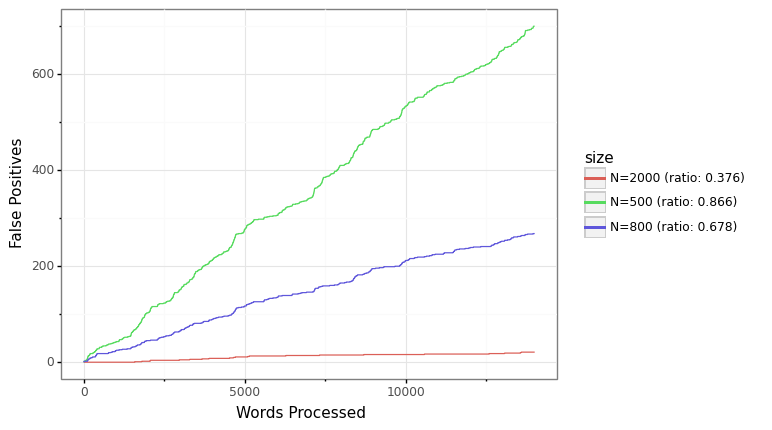

<ggplot: (8768014614709)>

In [7]:
!pip install plotnine
from plotnine import *

ggplot(aes(x='x', y='error', group='size', color='size'), data=df) + geom_step() \
    + xlab('Words Processed') + ylab('False Positives') + theme_bw()

# Interactive frontend

In [8]:
import ipywidgets as widgets
memorySizeInput = widgets.IntSlider(
    value=500,
    min=0,
    max=4000,
    step=10,
    description='Memory size:',
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
searchWordInput = widgets.Text(
    value='abelmoschus',
    description='Search word:'
)
searchButton = widgets.Button(description="Search")
searchOutput = widgets.Output()

countSizeSlider = widgets.IntSlider(
    value=500,
    min=0,
    max=4000,
    step=10,
    description='Memory size:',
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
countButton = widgets.Button(description="Count search hits")
countOutput = widgets.Output()

def on_search_button_clicked(b):
  with searchOutput:
    my_data = data[0:1000]
    my_filter = BloomFilter(my_data, memorySizeInput.value)
    print('N:', 
      memorySizeInput.value,
      '  Real:',
      searchWordInput.value in my_data,
      '  Bloom:',
      my_filter.search(searchWordInput.value)
    )

def on_count_button_clicked(b):
  with countOutput:
    error = bloom_count(countSizeSlider.value)
    print('N:', 
      countSizeSlider.value,
      '  Error count:',
      error
    )

searchButton.on_click(on_search_button_clicked)
countButton.on_click(on_count_button_clicked)

display(
  widgets.HTML(value='<h1>Bloom Filter</h1>'),
  widgets.HTML(value='<h2>Search (Personal Implementation)</h2>'),
  memorySizeInput,
  searchWordInput,
  searchButton,
  searchOutput,
  widgets.HTML(value='<h2>Count (Public Implementation)</h2>'),
  countSizeSlider,
  countButton,
  countOutput
)

HTML(value='<h1>Bloom Filter</h1>')

HTML(value='<h2>Search (Personal Implementation)</h2>')

IntSlider(value=500, description='Memory size:', max=4000, step=10)

Text(value='abelmoschus', description='Search word:')

Button(description='Search', style=ButtonStyle())

Output()

HTML(value='<h2>Count (Public Implementation)</h2>')

IntSlider(value=500, description='Memory size:', max=4000, step=10)

Button(description='Count search hits', style=ButtonStyle())

Output()

N: 500   Error count: 700
N: 590   Error count: 557
N: 3510   Error count: 5
N: 170   Error count: 1308
